In [1]:
import torch
import fm

from sklearn.decomposition import PCA

import seaborn as sns

In [4]:
# Load RNA-FM model
model, alphabet = fm.pretrained.rna_fm_t12("/Users/tobiaochsner/Documents/ETH/RNA-FM/redevelop/pretrained/RNA-FM_pretrained.pth")
batch_converter = alphabet.get_batch_converter()

torch.device("mps")
model.to("mps")

model.eval()  # disables dropout for deterministic results

RNABertModel(
  (embed_tokens): Embedding(25, 640, padding_idx=1)
  (layers): ModuleList(
    (0-11): 12 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (q_proj): Linear(in_features=640, out_features=640, bias=True)
        (out_proj): Linear(in_features=640, out_features=640, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=640, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=640, bias=True)
      (final_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=240, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 640, padding_idx=1)
  (emb_layer_norm_

In [57]:
import pandas as pd
from src.utils.sequences import dna_to_rna
from tqdm import tqdm
import numpy as np

df = pd.read_csv("../data/output/preprocessed.csv")

df = df

In [58]:
data = [
    (str(i), dna_to_rna(seq)) for i, seq in enumerate(df["mutated_wildtype_dna"])
]

In [59]:
len(data)

17615

In [60]:
mean_embeddings = []

batch_size = 256

for i in tqdm(range(0, len(data), 256)):
    batch = data[i : i + 256]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch)

    with torch.no_grad():
        results = model(batch_tokens.to("mps"), repr_layers=[12])

    token_embeddings = results["representations"][12]
    mean_embeddings.append(token_embeddings.mean(axis=1).cpu().numpy())


100%|██████████| 69/69 [07:17<00:00,  6.34s/it]


In [61]:
mean_embeddings = np.concatenate(mean_embeddings)

In [62]:
len(mean_embeddings)

17615

In [63]:
mean_embeddings.shape

(17615, 640)

In [78]:
pca = PCA(n_components=4)

In [79]:
pca_embeddings = pca.fit_transform(mean_embeddings)

In [80]:
pca_embeddings.shape

(17615, 4)

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='fitness'>

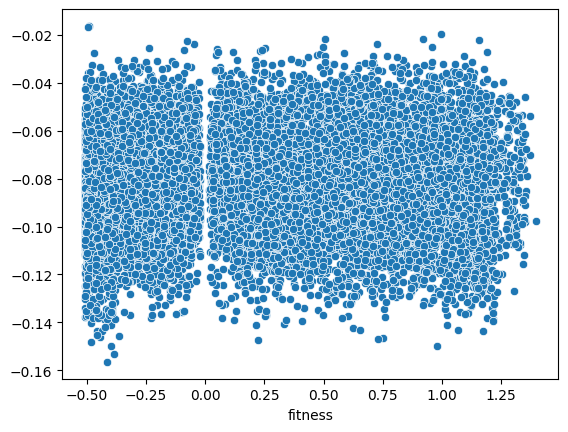

In [126]:
sns.scatterplot(x=df["fitness"], y=mean_embeddings[:, 635])

In [130]:
df["fitness"].corr(pd.Series(mean_embeddings[:, 635]))

0.01082292874492664

In [131]:
from src.analysis.correlation_with_fitness import correlation_with_fitness
from src.analysis.linear_regression import linear_regression
from src.analysis.random_forest_permutation_importance import random_forest_permutation_importance
from src.analysis.correlation_matrix import correlation_matrix
from src.factors.factors import mutated_amino_acids
from src.factors.factors import positionwise_mutated_nucleotides
from src.factors.factors import minimum_free_energy
from pathlib import Path

In [101]:
df[[f"fn_{i}" for i in range(640)]] = mean_embeddings

/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_90429/904880886.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"fn_{i}" for i in range(640)]] = mean_embeddings
/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_90429/904880886.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"fn_{i}" for i in range(640)]] = mean_embeddings
/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_90429/904880886.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [102]:
df = df.copy()

In [103]:
df = mutated_amino_acids(df)
# df = minimum_free_energy(df)
df = positionwise_mutated_nucleotides(df)

In [151]:
correlation_with_fitness(df, output_path=Path("."), variables=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "minimum_free_energy",
                                                                   "mutated_dna_0",
    "mutated_dna_1",
    "mutated_dna_2",
    "mutated_dna_3",
    "mutated_dna_4",
    "mutated_dna_5",
    "mutated_dna_6",
    "mutated_dna_7",
    "mutated_dna_8",
    "fn_635", "fn_171"], group_by=["mutated_amino_acids"])

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tobiaochsner/Documents/ETH/Geneti

<Figure size 640x480 with 0 Axes>

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


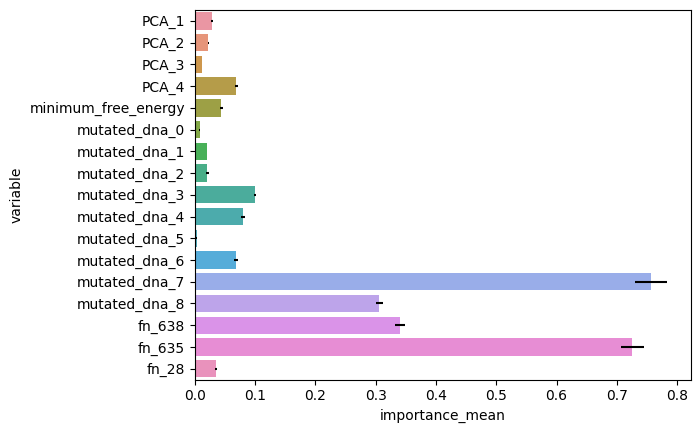

In [133]:
random_forest_permutation_importance(df, output_path=Path("."), variables=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "minimum_free_energy", 
    "mutated_dna_0",
    "mutated_dna_1",
    "mutated_dna_2",
    "mutated_dna_3",
    "mutated_dna_4",
    "mutated_dna_5",
    "mutated_dna_6",
    "mutated_dna_7",
    "mutated_dna_8",
] + ["fn_638", "fn_635", "fn_28"])

In [93]:
linear_regression(df, variables=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "mutated_amino_acids", "minimum_free_energy"])

2023-09-26 22:39:31.250 | INFO     | src.analysis.linear_regression:linear_regression:22 -                      Variable  Coefficient
0                       PCA_1    -0.081035
1                       PCA_2     0.168367
2                       PCA_3     0.117197
3                       PCA_4    -0.170509
4         minimum_free_energy     0.031132
...                       ...          ...
1705  mutated_amino_acids_YTH    -0.531574
1706  mutated_amino_acids_YTL    -0.339021
1707  mutated_amino_acids_YTT     0.099688
1708  mutated_amino_acids_YV*    -0.455267
1709  mutated_amino_acids_YVA    -0.359226

[1710 rows x 2 columns]
2023-09-26 22:39:31.459 | INFO     | src.analysis.linear_regression:linear_regression:23 - 0.9560251466546804


In [106]:
linear_regression(df, variables=["mutated_amino_acids", "minimum_free_energy"])

2023-09-26 22:56:17.280 | INFO     | src.analysis.linear_regression:linear_regression:22 -                      Variable   Coefficient
0         minimum_free_energy  2.565917e-02
1     mutated_amino_acids_*A* -8.477122e+08
2     mutated_amino_acids_*AI -8.477122e+08
3     mutated_amino_acids_*D* -8.477122e+08
4     mutated_amino_acids_*DA -8.477122e+08
...                       ...           ...
1701  mutated_amino_acids_YTH -8.477122e+08
1702  mutated_amino_acids_YTL -8.477122e+08
1703  mutated_amino_acids_YTT -8.477122e+08
1704  mutated_amino_acids_YV* -8.477122e+08
1705  mutated_amino_acids_YVA -8.477122e+08

[1706 rows x 2 columns]
2023-09-26 22:56:17.506 | INFO     | src.analysis.linear_regression:linear_regression:23 - 0.9532607367898561


In [118]:
linear_regression(df, variables=["mutated_amino_acids", "fn_635"])

2023-09-26 23:46:01.057 | INFO     | src.analysis.linear_regression:linear_regression:22 -                      Variable  Coefficient
0                      fn_635     0.060866
1     mutated_amino_acids_*A*    -1.485762
2     mutated_amino_acids_*AI    -1.095137
3     mutated_amino_acids_*D*    -1.409882
4     mutated_amino_acids_*DA    -1.083610
...                       ...          ...
1701  mutated_amino_acids_YTH    -1.444985
1702  mutated_amino_acids_YTL    -1.317520
1703  mutated_amino_acids_YTT    -0.817017
1704  mutated_amino_acids_YV*    -1.443256
1705  mutated_amino_acids_YVA    -1.396669

[1706 rows x 2 columns]
2023-09-26 23:46:01.147 | INFO     | src.analysis.linear_regression:linear_regression:23 - 0.9472195341468909


In [95]:
linear_regression(df, variables=["mutated_amino_acids"])

2023-09-26 22:39:45.286 | INFO     | src.analysis.linear_regression:linear_regression:22 -                      Variable   Coefficient
0     mutated_amino_acids_*A*  2.661948e+09
1     mutated_amino_acids_*AI  2.661948e+09
2     mutated_amino_acids_*D*  2.661948e+09
3     mutated_amino_acids_*DA  2.661948e+09
4     mutated_amino_acids_*DC  2.661948e+09
...                       ...           ...
1700  mutated_amino_acids_YTH  2.661948e+09
1701  mutated_amino_acids_YTL  2.661948e+09
1702  mutated_amino_acids_YTT  2.661948e+09
1703  mutated_amino_acids_YV*  2.661948e+09
1704  mutated_amino_acids_YVA  2.661948e+09

[1705 rows x 2 columns]
2023-09-26 22:39:45.482 | INFO     | src.analysis.linear_regression:linear_regression:23 - 0.9472166944519432


In [114]:
correlations = pd.read_csv("/Users/tobiaochsner/Documents/ETH/GeneticFitness/notebooks/random_forest_permutatuon_importances.csv")

In [115]:
correlations

,Unnamed: 0,importance_mean,importance_std,variable
0,0,0.000054,0.000025,PCA_1
1,1,0.000056,0.000037,PCA_2
2,2,0.000055,0.000017,PCA_3
3,3,0.000870,0.000083,PCA_4
4,4,0.001585,0.000126,minimum_free_energy
...,...,...,...,...
649,649,0.691648,0.018804,fn_635
650,650,0.035430,0.001811,fn_636
651,651,0.007942,0.000781,fn_637
652,652,0.502438,0.008821,fn_638


In [121]:
correlations.sort_values("importance_mean", ascending=False).head(50)

,Unnamed: 0,importance_mean,importance_std,variable
649,649,0.691648,0.018804,fn_635
652,652,0.502438,0.008821,fn_638
42,42,0.051871,0.002032,fn_28
650,650,0.035430,0.001811,fn_636
427,427,0.023477,0.001813,fn_413
648,648,0.021326,0.002357,fn_634
452,452,0.012891,0.000873,fn_438
646,646,0.012184,0.001096,fn_632
645,645,0.011947,0.000580,fn_631
484,484,0.009431,0.000924,fn_470


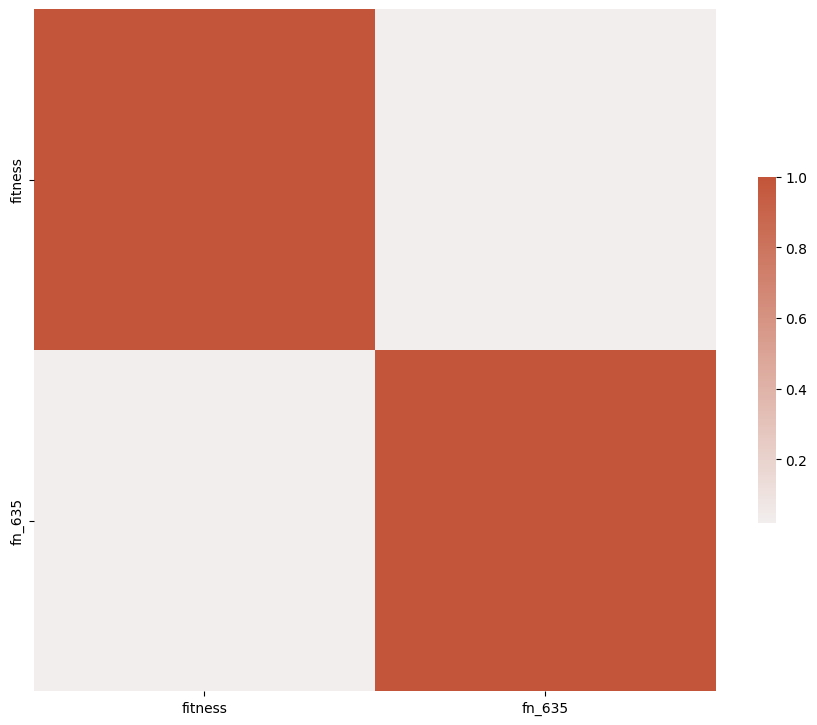

In [132]:
correlation_matrix(df, Path(), ["fitness", "fn_635"])

In [134]:
from sklearn.feature_selection import mutual_info_regression

In [145]:
mi = mutual_info_regression(df.select_dtypes(include="number"), df["fitness"])

In [149]:
mi = list(zip(df.select_dtypes(include="number").columns, mi))

In [150]:
sorted(mi, key=lambda x: x[1], reverse=True)

[('fitness', 8.519868032255689),
 ('standard_error', 0.5642498628424173),
 ('Unnamed: 0', 0.247161547225641),
 ('p_value', 0.1387734257790949),
 ('fn_171', 0.08466390470994867),
 ('fn_362', 0.0824776425601792),
 ('fn_7', 0.08143701703774564),
 ('fn_200', 0.0786065342876654),
 ('fn_359', 0.07690805022460623),
 ('fn_564', 0.07673356859769065),
 ('fn_218', 0.07077142990701368),
 ('fn_583', 0.06962094610663794),
 ('fn_14', 0.06580130979756937),
 ('fn_310', 0.06442584598918266),
 ('minimum_free_energy', 0.061813991820902636),
 ('fn_623', 0.061278052263037175),
 ('fn_553', 0.05995513418105247),
 ('fn_527', 0.055952867171614074),
 ('fn_432', 0.055127368405568866),
 ('fn_549', 0.054498215068570666),
 ('fn_149', 0.05351681422158627),
 ('fn_24', 0.05336817964267837),
 ('fn_472', 0.05196162779454294),
 ('fn_299', 0.05157590534320189),
 ('fn_338', 0.051123601744568425),
 ('fn_86', 0.04861977815115548),
 ('fn_163', 0.04849332312471155),
 ('fn_428', 0.04828744570971022),
 ('fn_354', 0.04796492816916

In [144]:
df.select_dtypes(include="number").columns

Index(['Unnamed: 0', 'fitness', 'p_value', 'standard_error', 'PCA_1', 'PCA_2',
       'PCA_3', 'PCA_4', 'minimum_free_energy', 'fn_0',
       ...
       'fn_630', 'fn_631', 'fn_632', 'fn_633', 'fn_634', 'fn_635', 'fn_636',
       'fn_637', 'fn_638', 'fn_639'],
      dtype='object', length=649)